In [42]:
import pandas as pd
df = pd.read_csv("../Data/lstm.csv")
df.head()

,paragraph,category
0,dishplace is located in sunnyvale downtown the...,food
1,service can be slower during busy hours but ou...,food
2,portions are huge both french toast and their ...,food
3,we started with apps going the chicken and waf...,food
4,the biscuits and gravy was too salty two peopl...,food


In [43]:
df.category.unique()

array(['food', 'sports'], dtype=object)

In [44]:
# 데이터에 사용된 중복 없는 전체 단어 갯수를 파악
results = set()
df['paragraph'].str.lower().str.split().apply(results.update)
vocab_size = len(results)
vocab_size

536

In [45]:
# 단어를 숫자로 인코딩
paragraphs = df['paragraph'].to_list() # 길이가 다 다르면 넘파이 못씀
paragraphs[:5]

['dishplace is located in sunnyvale downtown there is parking around the area but it can be difficult to find during peak business hours my sisters and i came to this place for dinner on a weekday they were really busy so i highly recommended making reservations unless you have the patience to wait',
 'service can be slower during busy hours but our waiter was courteous and help gave some great entree recommendations',
 'portions are huge both french toast and their various omelettes are really good their french toast is probably 1.5x more than other brunch places great place to visit if you are hungry and dont want to wait 1 hour for a table',
 'we started with apps going the chicken and waffle slides and chicken nachos the sliders were amazing and the nachos were good too maybe by themselves the nachos would have scored better but after those sliders they were up against some tough competition',
 'the biscuits and gravy was too salty two people in my group had the gravy and all thoug

In [46]:
from tensorflow import keras
keras.utils.set_random_seed(1) # set seed 는 넘파이에서도 할 수 있고 keras에서도 쌉가능

In [47]:
# one hot encoding
encoded_paragraphs = [keras.preprocessing.text.one_hot(paragraph, vocab_size) for paragraph in paragraphs]
encoded_paragraphs

[[36,
  22,
  68,
  210,
  459,
  269,
  492,
  22,
  187,
  460,
  510,
  339,
  82,
  202,
  310,
  334,
  123,
  325,
  369,
  467,
  332,
  407,
  416,
  489,
  501,
  484,
  511,
  346,
  325,
  169,
  11,
  142,
  119,
  248,
  429,
  87,
  37,
  456,
  187,
  533,
  430,
  511,
  252,
  494,
  295,
  187,
  158,
  52,
  144,
  510,
  231,
  325,
  417],
 [462,
  310,
  334,
  352,
  467,
  533,
  416,
  82,
  49,
  254,
  193,
  505,
  484,
  143,
  326,
  141,
  36,
  283,
  126],
 [513,
  409,
  290,
  125,
  24,
  56,
  484,
  416,
  417,
  147,
  409,
  187,
  401,
  416,
  24,
  56,
  22,
  478,
  428,
  171,
  471,
  106,
  276,
  442,
  423,
  36,
  11,
  325,
  195,
  143,
  52,
  409,
  503,
  484,
  511,
  37,
  325,
  417,
  428,
  490,
  142,
  429,
  453],
 [346,
  94,
  323,
  181,
  533,
  510,
  292,
  484,
  431,
  96,
  484,
  292,
  356,
  510,
  335,
  456,
  408,
  484,
  510,
  356,
  456,
  401,
  226,
  351,
  272,
  52,
  510,
  356,
  28,
  144,
  347,


In [48]:
# 데이터에서 가장 긴 문장의 단어 갯수 확인

max_length = 0
for row in df['paragraph']:
    if len(row.split(" ")) > max_length:
        max_length = len(row.split(" "))
print(max_length)

91


In [49]:
# 문장마다 단어 갯수가 다르므로 sequence padding을 넣어서 문장의 길이를 동일하게 만듭니다.

padded_paragraph_encoding = keras.preprocessing.sequence.pad_sequences(encoded_paragraphs, maxlen= max_length, padding = 'post') # padding = post면 0값이 뒤로 들어값 안적으면 앞으로 들어감
padded_paragraph_encoding

array([[ 36,  22,  68, ...,   0,   0,   0],
       [462, 310, 334, ...,   0,   0,   0],
       [513, 409, 290, ...,   0,   0,   0],
       ...,
       [236, 467, 142, ...,   0,   0,   0],
       [ 82, 510, 163, ...,   0,   0,   0],
       [116, 346, 510, ...,   0,   0,   0]], dtype=int32)

In [50]:
# 분류항목(food,sports)를 수치로 변경하기
categories = df['category'].to_list()

def category_encode(category):
    if category == 'food':
        return [1,0]
    else:
        return [0,1]

In [51]:
encoded_category = [category_encode(category) for category in categories ]
encoded_category

[[1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1]]

In [52]:
print(encoded_paragraphs[0])

[36, 22, 68, 210, 459, 269, 492, 22, 187, 460, 510, 339, 82, 202, 310, 334, 123, 325, 369, 467, 332, 407, 416, 489, 501, 484, 511, 346, 325, 169, 11, 142, 119, 248, 429, 87, 37, 456, 187, 533, 430, 511, 252, 494, 295, 187, 158, 52, 144, 510, 231, 325, 417]


In [54]:
len(encoded_paragraphs[19])

73

---
## 주제를 분류하는 모델 구현하기

In [94]:
model = keras.Sequential()
# 문맥 생성 단계
model.add(keras.layers.Embedding(vocab_size, 4, input_length= max_length)) # 임베딩 레이어는 인덱스를 받아 5차원 벡터의 임베딩을 출력합니다.
# 영어라서 5개 하이퍼파라미터로 설정했는데 문장 형식 5형식이라 5씀

model.add(keras.layers.LSTM(64))

# 분류 단계
model.add(keras.layers.Dense(32, activation = 'relu'))
model.add(keras.layers.Dense(2, activation = 'softmax')) # 2가지 답이지만 문장은 확률 값이어야되서? 소프맥스씀

In [95]:

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = 'accuracy'
)

In [96]:
import numpy as np

train_X = np.array(padded_paragraph_encoding)
train_Y = np.array(encoded_category)



In [97]:
history = model.fit(train_X,train_Y,batch_size=10, epochs = 50)

Epoch 1/50
2/2 [==============================] - 1s 10ms/step - loss: 0.6942 - accuracy: 0.5500
Epoch 2/50
2/2 [==============================] - 0s 11ms/step - loss: 0.6925 - accuracy: 0.5000
Epoch 3/50
2/2 [==============================] - 0s 14ms/step - loss: 0.6923 - accuracy: 0.6000
Epoch 4/50
2/2 [==============================] - 0s 14ms/step - loss: 0.6923 - accuracy: 0.6000
Epoch 5/50
2/2 [==============================] - 0s 11ms/step - loss: 0.6921 - accuracy: 0.5500
Epoch 6/50
2/2 [==============================] - 0s 11ms/step - loss: 0.6917 - accuracy: 0.5000
Epoch 7/50
2/2 [==============================] - 0s 11ms/step - loss: 0.6912 - accuracy: 0.5500
Epoch 8/50
2/2 [==============================] - 0s 11ms/step - loss: 0.6907 - accuracy: 0.6000
Epoch 9/50
2/2 [==============================] - 0s 10ms/step - loss: 0.6902 - accuracy: 0.6000
Epoch 10/50
2/2 [==============================] - 0s 11ms/step - loss: 0.6898 - accuracy: 0.6000
Epoch 11/50
2/2 [============

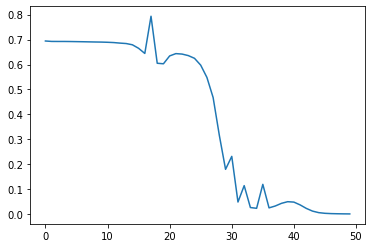

In [98]:
import matplotlib.pyplot as plt
plt.plot (
    history.history['loss']
)